# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm, tqdm_notebook, tnrange
import tensorflow as tf
import math
import os


Using TensorFlow backend.


In [3]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "/home/shreyas/Documents/sdcND/data/lab2/train.p"
testing_file = "/home/shreyas/Documents/sdcND/data/lab2/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# number of training examples
n_train = len(X_train)
# TODO: number of testing examples
n_test = len(X_test)
# TODO: what's the shape of an image?
image_shape = X_train[0].shape
# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [2]:
### import and extract the signnames
signnames = []
with open('signnames.csv', newline='') as csvfile:
    signname_file = csv.reader(csvfile)
    next(signname_file, None)
    for row in signname_file:
        signnames.append(row[1])

In [3]:
def plot_img(images, labels, pred_labels=None):
    '''
    images - 5 given images to plotted
    labels - true labels of images
    pred_labels - predicted labels
    Creates a 1x5 plot for given images'''
   
    f, axes = plt.subplots(1,5,figsize=(12, 3))
    f.subplots_adjust(wspace=.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        #sinplot()
        
        if pred_labels is None:
            xlabel = "{}\n{}".format(labels[i], signnames[labels[i]])
        else:
            xlabel = "given {}: {}\npredicate {}: {}".format(labels[i], signnames[labels[i]], 
                                                             pred_labels[i], signnames[pred_labels[i]])
        
        ax.set_xlabel(xlabel)
        #remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])

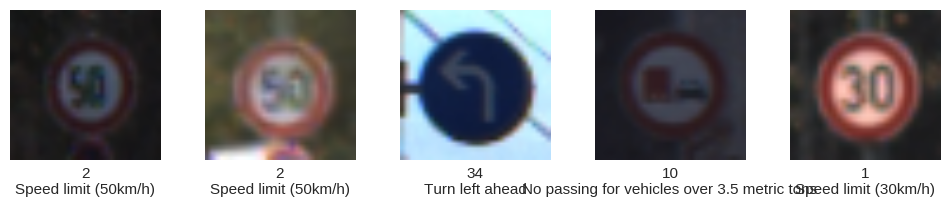

In [6]:
images = np.random.choice(len(X_train),5)
plot_img(X_train[images], y_train[images])

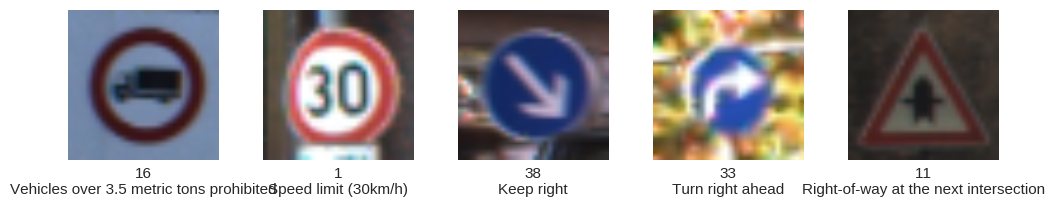

In [7]:
plot_img(X_test[:5],y_test[:5])

In [8]:
from collections import Counter
data_distribution = Counter(y_train)
label_list = set(y_train)
len(label_list)

43

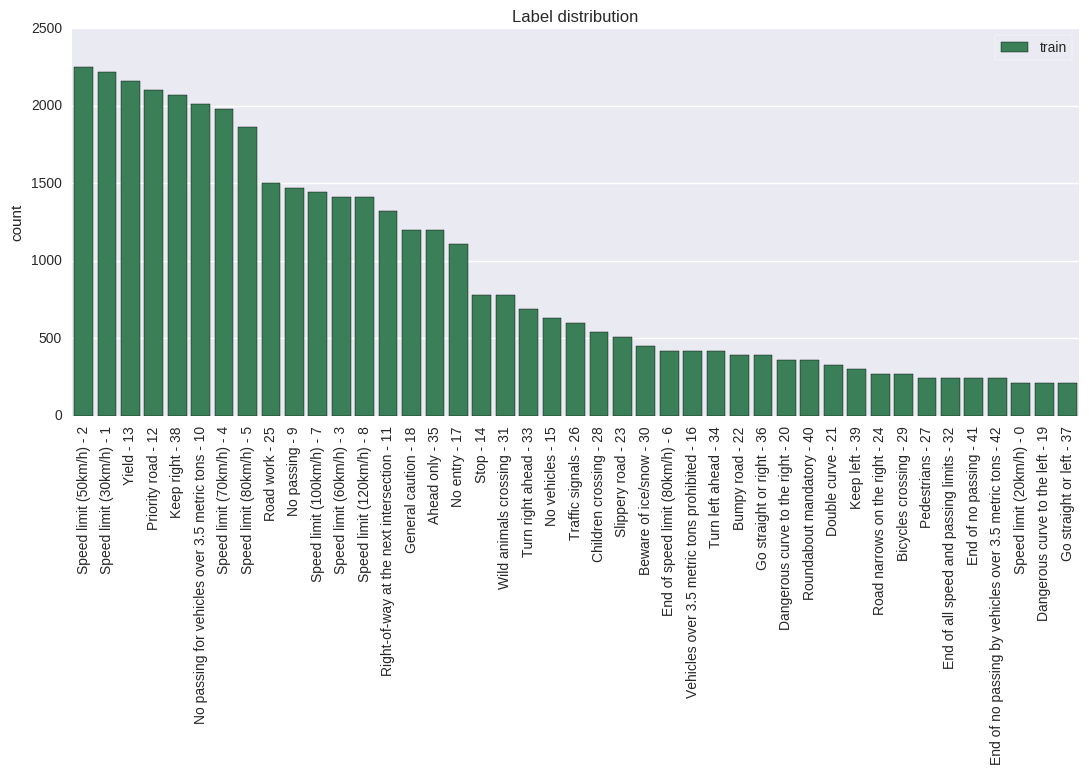

In [9]:
order = list(zip(*data_distribution.most_common()))[0]

f, ax = plt.subplots(figsize=(13, 5))
ax = sns.countplot(x=y_train, order=order, color='seagreen', ax=ax, label="train")

#ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Label distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
def augument_data(x, y,
                  rotation = 29, 
                  trans_range = 0.3, 
                  channel_shift = 0.01):
    
    datagen = ImageDataGenerator(rotation_range=rotation,                           
                                 channel_shift_range=channel_shift,
                                 shear_range=trans_range,
                                 zoom_range=trans_range,
                                 width_shift_range=trans_range,
                                 height_shift_range=trans_range,
                                 fill_mode='nearest')

    datagen.fit(x, seed=42)
    batch_size = min(x.shape[0],(1781-x.shape[0]))
    nb_transforms = int(math.ceil(1700/x.shape[0]))-1
    #print ("batchsize: {}, nb_transforms: {}".format(batch_size, nb_transforms))
    for i in range(nb_transforms):       
        X_batch, y_batch = next(datagen.flow(x, y, batch_size=batch_size, seed=42))

        x = np.concatenate((x, X_batch), axis=0)
        y = np.concatenate((y, y_batch), axis=0)
        
    return x,y

In [12]:
X_a = np.zeros(shape=(0,32,32,3))
y_a = np.zeros(shape=(0,))

for label in label_list:
        index_list = [i for i, x in enumerate(y_train) if x == label]
        x_b, y_b = augument_data(X_train[index_list], y_train[index_list])
        X_a = np.concatenate((X_a, x_b), axis=0)
        y_a = np.concatenate((y_a, y_b), axis=0)
        #print (label, len(y_a))

In [13]:
aug_data_distribution = Counter(y_a)

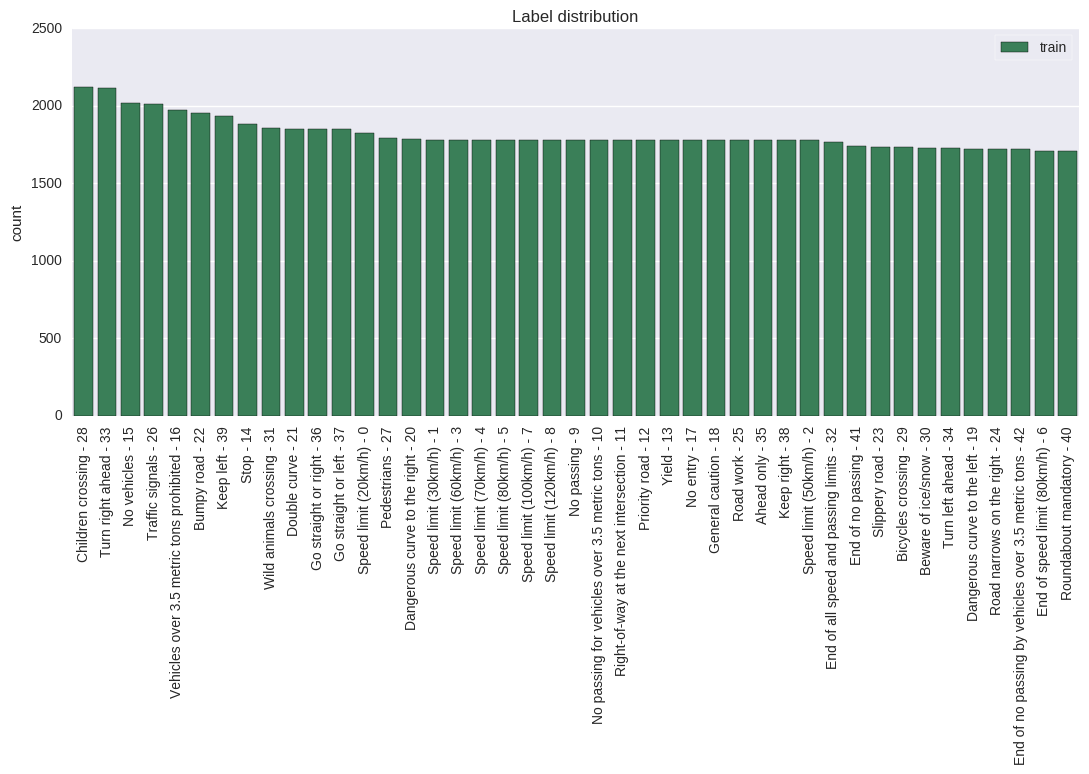

In [14]:
order_list = list(zip(*aug_data_distribution.most_common()))[0]
order = [int(indices) for indices in order_list]
f, ax = plt.subplots(figsize=(13, 5))
ax = sns.countplot(x=y_a, order=order, color='seagreen', ax=ax, label="train")

#ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Label distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

In [15]:
#normalize features so that all values are be
X_train = X_a.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_a

X_train /= 255
X_valid /= 255
X_test /= 255

In [16]:
import os
# Save the data for easy access
pickle_file = '/home/shreyas/Documents/sdcND/data/traffic_signs.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train,
                    'train_labels': y_train,
                    'valid_dataset': X_valid,
                    'valid_labels': y_valid,
                    'test_dataset': X_test,
                    'test_labels': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm, tqdm_notebook, tnrange
import tensorflow as tf
import math
import os


Using TensorFlow backend.


In [4]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import pickle

pickle_file = '/home/shreyas/Documents/sdcND/data/udacity_traffic_signs.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['train_dataset']
  y_train = pickle_data['train_labels']
  X_valid = pickle_data['valid_dataset']
  y_valid = pickle_data['valid_labels']
  X_test = pickle_data['test_dataset']
  y_test = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


In [5]:
print (y_valid.shape, y_test.shape, y_train.shape)
print (X_valid.shape, X_test.shape, X_train.shape)

(7842,) (12630,) (31367,)
(7842, 32, 32, 3) (12630, 32, 32, 3) (31367, 32, 32, 3)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def weights(shape):
    return tf.Variable(tf.truncated_normal(shape, mean=0.0, stddev=0.1))


def biases(length):
    return tf.Variable(tf.zeros(length))


def conv2d(x, nb_filter,
           filter_size=[1,1],  
           strides=[1,1,1,1],
           padding='SAME',
           batch_norm=False,  
           is_training=False):
    
    # get shape for weight tensor
    nb_channel = int(x.get_shape()[3])
    shape = [filter_size[0], filter_size[1], nb_channel, nb_filter]
    
    # initiate the weights
    W = weights(shape)
    # convolution
    layer = tf.nn.conv2d(x, W, strides=strides, padding=padding)
    
    # batch_normalisation   
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, scale=True, updates_collections=None, is_training=is_training)
    else:
        b = biases(nb_filter)
        layer = tf.add(layer, b)
        
    return layer



def flatten(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features], name='flatten')
    return layer_flat, num_features



def dense(x, 
          nb_input, 
          nb_output,
          batch_norm=False,
          is_training=False,
          relu=True):
    
    # get shape for weight tensor
    shape = [nb_input, nb_output]
    # intitiate weight matrix
    W = weights(shape)
    layer = tf.matmul(x,W)
    
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, scale=True, updates_collections=None, is_training=is_training)
    else:
        b = biases(nb_output)
        layer = tf.add(layer,b)
    # perform relu activation
    if relu:
        layer = tf.nn.relu(layer)
    
    return layer


def max_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME'):
    return tf.nn.max_pool(x, ksize=ksize, strides=strides, padding=padding)
    

def avg_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME'):
    return tf.nn.avg_pool(x, ksize=ksize, strides=strides, padding=padding)

def combined_pool(x):
    return tf.add(max_pool(x),avg_pool(x))

In [7]:
def model1(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 
    
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=128, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv3x3 = conv2d(conv1x1, nb_filter=128, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv3x3 = tf.nn.relu(conv3x3)
    conv1x1 = conv2d(conv3x3, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 4096, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
    
    
    # output layer
    output = dense(dropout, 4096, 43, relu=False) 
    return output

In [8]:
def model2(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 
    
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=128, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
        
    net = tf.add(conv1x1, pool)
    net = tf.nn.relu(net)
    pool = combined_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 
    
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv3x3 = conv2d(conv1x1, nb_filter=128, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv3x3 = tf.nn.relu(conv3x3)
    conv1x1 = conv2d(conv3x3, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    net = tf.add(conv1x1, pool)
    net = tf.nn.relu(net)
    pool = combined_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 4096, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
          
    # output layer
    output = dense(dropout, 4096, 43, relu=False) 
    return output

In [9]:
def model3(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 - inception
    branch_pool = avg_pool(conv1x1)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch2_conv3x3 = conv2d(branch_conv3x3, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
        
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch2_conv3x3])
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 - inception
    branch_pool = avg_pool(net)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch_conv5x5 = conv2d(conv1x1, nb_filter=96, filter_size=[5,5], batch_norm=True, is_training=is_training)
    
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch_conv5x5])
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 4096, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
        
    # output layer
    output = dense(dropout, 4096, 43, relu=False) 
    return output

In [10]:
def model4(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=384, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 - inception
    branch_pool = avg_pool(conv1x1)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch2_conv3x3 = conv2d(branch_conv3x3, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
        
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch2_conv3x3])
    net = tf.add(pool,net)
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 - inception
    branch_pool = avg_pool(net)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch_conv5x5 = conv2d(conv1x1, nb_filter=96, filter_size=[5,5], batch_norm=True, is_training=is_training)
    
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch_conv5x5])
    net = tf.add(pool,net)
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 4096, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
   
    # output layer
    output = dense(dropout, 4096, 43, relu=False) 
    return output

In [11]:
def get_accuracy(y_pred, y):
    #y_pred = tf.nn.softmax(logits)
    correct_pred = tf.equal(tf.argmax(y_pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return accuracy

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        acc, cost = sess.run([accuracy,loss], feed_dict={X: batch_x, y: batch_y, keep_prob:1, is_training:False})
        total_accuracy += (acc * len(batch_x))
        total_loss += cost
    return total_accuracy/num_examples, total_loss/num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [12]:
# placeholder for input and outputs
X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int64, (None))
keep_prob = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, [])

In [13]:
### Train your model here.
### Feel free to use as many code cells as needed.
logits =model1(X, keep_prob, is_training)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(3e-4).minimize(loss)

accuracy = get_accuracy(logits, y)

In [14]:
batch_size = 128 

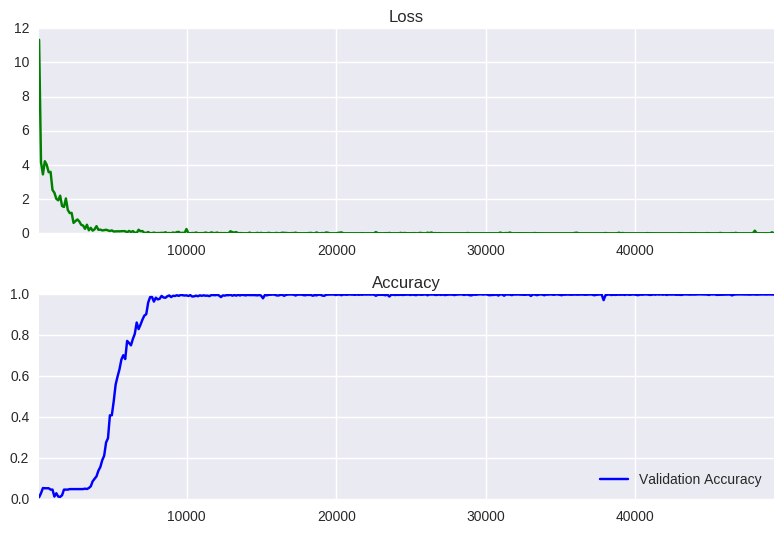

Best Validation loss at 0.9997449630196379 last iteration 44279
Validation accuracy at (0.99885233358837033, 4.7315838112412706e-05)


In [15]:
n_epochs = 200
epoch = 0
done_training = False
# The accuracy measured against the validation set
valid_accuracy = 0.0
best_valid_accuracy = 0.0
last_iteration = 0
improvement_threshold = 1.005

# Measurements use for graphing loss and accuracy
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

save_dir =  'model1s/'

saver = tf.train.Saver(tf.global_variables())
init = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_train)/batch_size))

    while (epoch < n_epochs) and (not done_training):
        epoch = epoch + 1
        
        # Progress bar
        #batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch, n_epochs), unit='batches')
        
        # The training cycle
        for batch_i in range(batch_count):
            iteration = (epoch - 1) * batch_count + batch_i
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            X_batch = X_train[batch_start:batch_start + batch_size]
            y_batch = y_train[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run([optimizer, loss],feed_dict={X: X_batch, y: y_batch, keep_prob:0.5, is_training:True})

            # Log every 50 batches
            if not iteration % batch_size:
                # Calculate Training and Validation accuracy
                #training_accuracy = evaluate(X_train, y_train)
                valid_accuracy, valid_loss = evaluate(X_valid, y_valid)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(batch_size + previous_batch)
                loss_batch.append(l)
                #train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(valid_accuracy)
            
            if not iteration % 512:
                if valid_accuracy > best_valid_accuracy:
                    best_valid_accuracy = valid_accuracy
                    last_iteration = iteration
                    checkpoint_path = os.path.join(save_dir, 'model.ckpt')
                    saver.save(session, checkpoint_path, global_step=iteration)
                
            if last_iteration - iteration > 987:
                done_training = True
                break
        

        # Check accuracy against Validation data
        validation_accuracy = evaluate(X_valid, y_valid)
        #print('Validation accuracy at {}'.format(validation_accuracy))
        if valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy
            last_iteration = iteration
            checkpoint_path = os.path.join(save_dir, 'session.ckpt')
            saver.save(session, checkpoint_path, global_step=iteration)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
#acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Best Validation loss at {} last iteration {}'.format(best_valid_accuracy, last_iteration))
print('Validation accuracy at {}'.format(validation_accuracy))

In [16]:
save_dir = 'model1s/'
with tf.Session() as session:
        saver = tf.train.Saver(tf.global_variables())
        ckpt = tf.train.latest_checkpoint(save_dir)
        saver.restore(session, ckpt)
        test_acc, test_loss = evaluate(X_test, y_test)
print("Test accuracy for augmented and balanced data with bottle-neck: {}".format(test_acc))


Test accuracy for augmented and balanced data with bottle-neck: 0.9683293744296378


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy import ndimage
import scipy as sp

In [18]:
x_images = []
y_images = []
dir_path = "/home/shreyas/Documents/sdcND/data/test_images/"
for image in os.listdir(dir_path):
        x_images.append(ndimage.imread(dir_path + image))
        y_images.append(int(image.split('.')[0]))
        
x_images = np.array(x_images)
y_images = np.array(y_images)
x_images /= 255

print(x_images[2].shape)

(601, 600, 3)


In [19]:
#resize images to match the model input
x_images = np.array([sp.misc.imresize(img, [32,32]) for img in x_images])

print(x_images[0].shape)

(32, 32, 3)


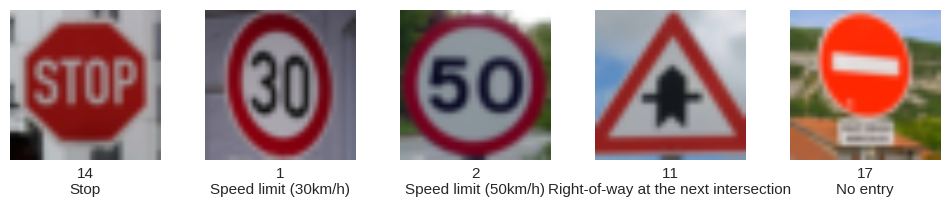

In [20]:
plot_img(x_images[:5],y_images[:5])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [21]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
save_dir = 'model1s/'

top_k = tf.nn.top_k(logits, k=5, sorted=True)
    
with tf.Session() as session:
        saver = tf.train.Saver(tf.global_variables())
        ckpt = tf.train.latest_checkpoint(save_dir)
        saver.restore(session, ckpt)
        test_acc, top_5= session.run([accuracy,top_k], feed_dict={X: x_images, y: y_images, keep_prob:1.0, is_training:False})
print("Test accuracy for original and imbalanced data with bottle-neck: {}".format(test_acc))
#print(top_5)

Test accuracy for original and imbalanced data with bottle-neck: 0.6000000238418579


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [22]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import pandas as pd
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.concatenate((y_train, y_test), axis=0))
def one_hot_encoding(data, lb):
    encoded = np.array(lb.transform(data))
    encoded_cls = lb.inverse_transform(encoded)
    
    return encoded, encoded_cls
y_images, y_cls = one_hot_encoding(y_images, lb)

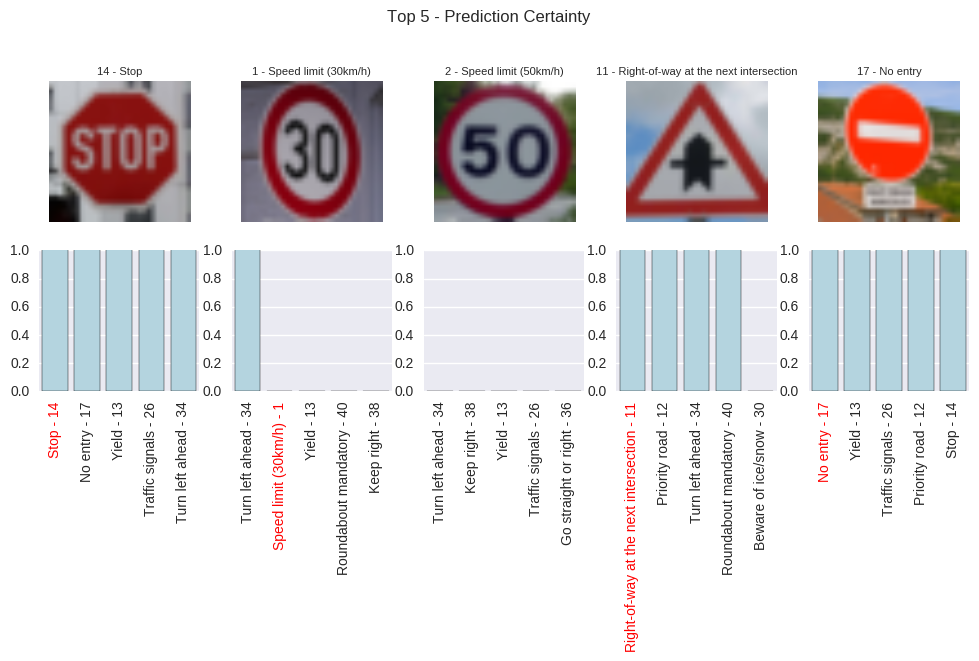

In [23]:
f, axarr = plt.subplots(2, 5, figsize=(12, 4))
f.suptitle('Top 5 - Prediction Certainty', fontsize=12, y=1.08)

for i, ax in enumerate(axarr[0]):
    ax.imshow(x_images[i])
    ax.set_title('%s - %s' % (y_cls[i], signnames[y_cls[i]]), fontsize=8)
    ax.axis('off')

for i, ax in enumerate(axarr[1]):
    data = pd.DataFrame([top_5.values[i]])
    ax.set_ylim([0, 1.0])
    sns.barplot(data=data, ax=ax, color='lightblue', ci=None)
    
    _ = ax.set_xticklabels(['%s - %s'% (signnames[j], j) for j in top_5.indices[i]], rotation=90)
    
    [tick.set_color("red") for j, tick in enumerate(ax.get_xticklabels()) if top_5.indices[i][j] == y_cls[i]]

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.